### last updated 3/27/2020
### It is a very simple model to track the progress of Covid in major countries and estimate if the exponential (explosive) spread of the virus is slowing down 
+ I fit the data to an exponential function N=I x exp(Ke*days). And by looking at the data fit of (1) all data; (2) the most recent 5-7 day data; (3) and setdiff([1],[2]) and examining how Ke - the constant in the exponent - changes, we can compare the "explosiveness" of the spread (the higher Ke, the faster the spread) and weather the spread is slowing down (significant drop in Ke)

###  China: 
+ Rapid spread happened around Jan-22 - Feb05 (for about 2 weeks) with Ke=0.197. The turning point occured around  with Ke drop to around 0.075 in the 7 day after. The predicted number for Feb-18 (~77k) slightly overshoot the acutal number (~74k).

### Italy: 
+ Rapid spread happened around Feb-23 - Mar21 (about 4 weeks) with Ke=0.149. It suggests Italy was 1 month behind China and spread slower. On Mar21, with Ke drop to around 0.078. It sugguested the worst is likely over. Predicted number is around 150k cases

### Spain: 
+ Rapid spread started around  Mar-09 and is ongoing. Ke is about 0.274, worse than Italy. The prediction is it is going to last quite a few more weeks

### US:
+ US is unquestionably the worst. Rapid spread started around the same time as in Spain (6 weeks behind China and 2 weeks behind Italy). Ke =0.317 was the highest. The most recent 7 day Ke is 0.219, still very explosive. It suggests there is likely quite a few weeks of rapid growth in US left. And we may see numbers above 400K in a week.

#### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from scipy.optimize import curve_fit
from datetime import datetime,timedelta

#### Define the fitting function, which is a simple expoential function -- what really matters is the exponent constant

In [2]:
def func(x, I0, k):     # a = I0, b = k
  # return I0 * np.exp(k*(x-x[0]+1))    
  return I0 * np.exp(k*x)    

#### Setup Analysis parameters, Import the data and seperate into more recent and "old" ones

In [3]:
start={
       "China": "2020-01-22",
       "US"   : "2020-03-01",
       "Spain": "2020-03-05",
       "Italy": "2020-02-22"
    }
Nback  = 5 # use a number of days to check if trend has changed
Nfwd   = 7

# import and print out data
df = pd.read_csv('data.csv',delim_whitespace=True, parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])
dNow   = datetime.now() - timedelta(days=1)            # today
print ('Tablulated Positive Covid-19 Cases for countries of interest')
display(HTML(df.loc[df['Date']<dNow,:].to_html(index=False,float_format="%d",border=2)))

Tablulated Positive Covid-19 Cases for countries of interest


Date,China,Italy,Spain,US
2020-01-22,571,0,0,0
2020-01-23,830,0,0,0
2020-01-24,1287,0,0,0
2020-01-25,1975,0,0,0
2020-01-26,2744,0,0,0
2020-01-27,4515,0,0,0
2020-01-28,5974,0,0,0
2020-01-29,7711,0,0,0
2020-01-30,9692,0,0,0
2020-01-31,11791,0,0,0


#### function to analyze one country's data 

In [4]:
def analyze_case(country):
    # seperate into different segment
    if country=="China": 
        dEnd = pd.to_datetime("2020-02-12")  # china starts early and ends early
    else:
        dEnd = dNow
    dTurn1 = dEnd - timedelta(days=Nback+1)      # go bkwd to seperate old from recent 
    dTurn2 = dEnd - timedelta(days=Nback+2)
    dFwd   = dEnd + timedelta(days=Nfwd-1)       # go a few days fwd for prediction
    dStart = pd.to_datetime(start[country])                   # each country start to have cases accelerating at differnt time
    
    df0 = df.loc[(df.Date>dStart)  & (df.Date<dEnd) ,:]       # all data to be analyzed
    df1 = df.loc[(df.Date>dStart)  & (df.Date<dTurn1) ,:]     # "old" data
    df2 = df.loc[(df.Date>=dTurn2) & (df.Date<dEnd),:]       # recent data
    df3 = df.loc[(df.Date>dStart)  & (df.Date<dFwd) ,:]      # forcast
    my_xticks = df3["Date"].dt.strftime("%b%d")
    
    # optimal data fitting for each segment
    y0 = df0[country]
    y1 = df1[country]
    y2 = df2[country]
    x0 = np.arange(1,len(y0)+1)
    x1 = np.arange(1,len(y1)+1)
    x2 = np.arange(len(y0)-len(y2)+1,len(y0)+1)
    x3 = np.arange(len(y0)+1,len(y0)+Nfwd+1)
    popt0, pcov = curve_fit(func, x0, y0)
    popt1, pcov = curve_fit(func, x1, y1)
    popt2, pcov = curve_fit(func, x2, y2)
 
    # print out summary of results
    print ("Exponent Values:")
    print ("  all data     = %.3f" % popt0[1])
    print ("  old data     = %.3f" % popt1[1]) 
    print ("  recent data  = %.3f" % popt2[1])
    print ("predicted cases at the end of next %d days is [%d]" % (Nfwd,func(x3, *popt2)[-1]))
    #dfp = pd.DataFrame( columns = ['Date', 'Case']) 
    #dfp.Date = my_xticks.tail(Nfwd)
    #dfp.Case = func(x3, *popt2)
    #print(dfp)
    
    # plot results    
    fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(x0, func(x0, *popt0), 'b--', label="all fit")  
    plt.plot(x1, y1, 'bo',label="past data")
    plt.plot(x1, func(x1, *popt1), 'b', label="past fit")  
    plt.plot(x2, y2, 'md',label="recent data")
    plt.plot(x2, func(x2, *popt2), 'm', label="recent fit") 
    plt.plot(x3, func(x3, *popt2), 'ro', label="Forcast Based on Latest Fit")  
    plt.xticks(np.append(x0,x3),my_xticks, rotation='vertical')
    #plt.xticks(x2, my_xticks2, rotation='vertical')
    plt.ylabel('# of cases')
    #plt.title(r'$N = '+f'{popt[0]:.3f}'+'*exp^{('+f'{popt[1]:.3f}'+'*days)}$')
    plt.title(country +r': $N_{all} = I_{all}'+'*e^{('+f'{popt0[1]:.3f}'+'*days)}$;  ' + r'$N_{past} = I_{past}'+'*e^{('+f'{popt1[1]:.3f}'+'*days)}$' + r';   $N_{latest} = I_{latest}'+'*e^{('+f'{popt2[1]:.3f}'+'*days)}$',fontsize=16, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()

Exponent Values:
  all data     = 0.126
  old data     = 0.197
  recent data  = 0.075
predicted cases at the end of next 7 days is [77240]


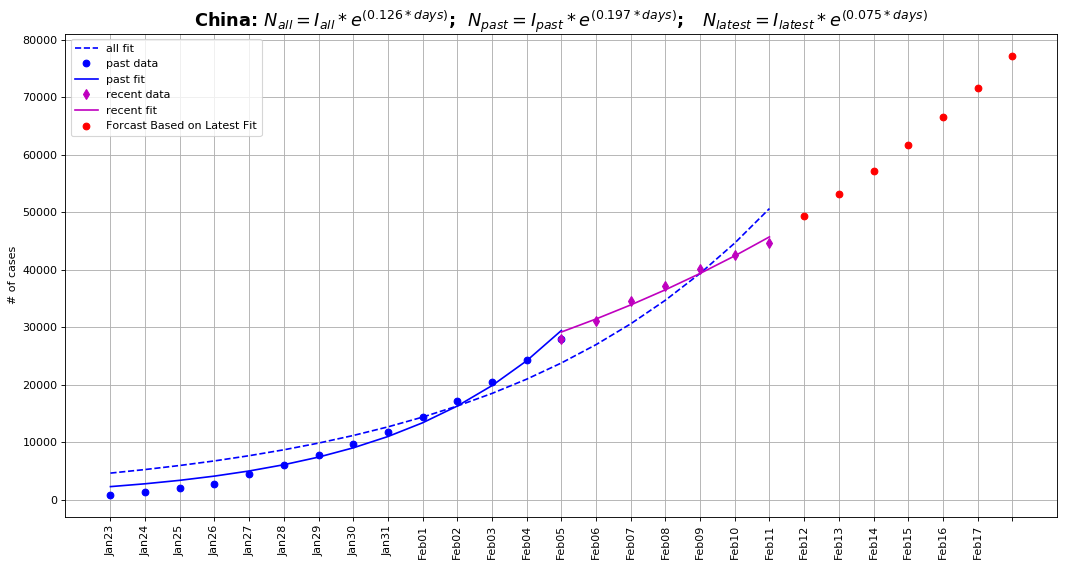

In [5]:
analyze_case("China")

Exponent Values:
  all data     = 0.115
  old data     = 0.149
  recent data  = 0.078
predicted cases at the end of next 7 days is [150154]


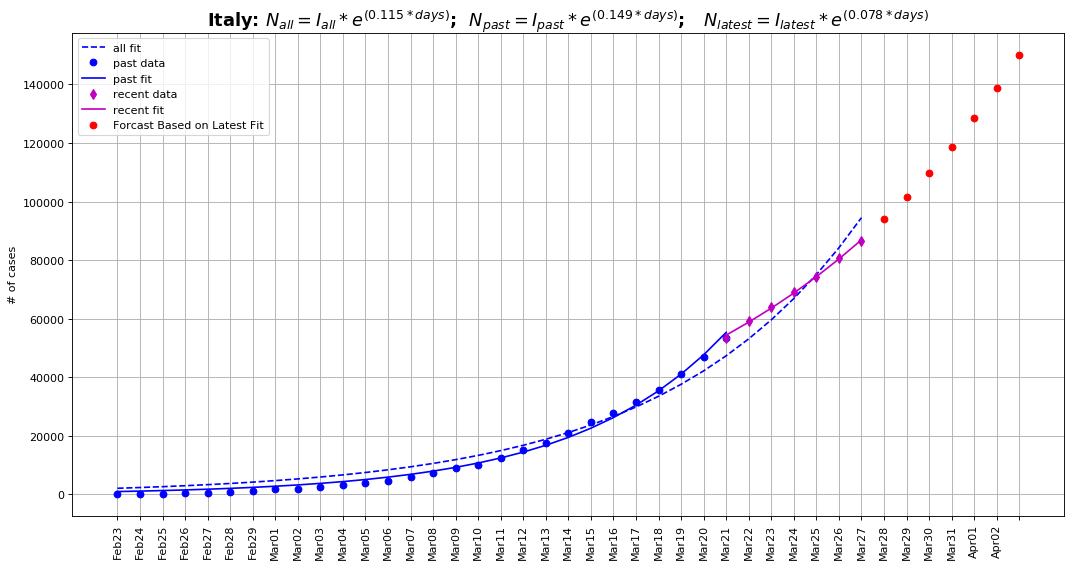

In [6]:
analyze_case("Italy")

Exponent Values:
  all data     = 0.223
  old data     = 0.274
  recent data  = 0.205
predicted cases at the end of next 7 days is [22228]


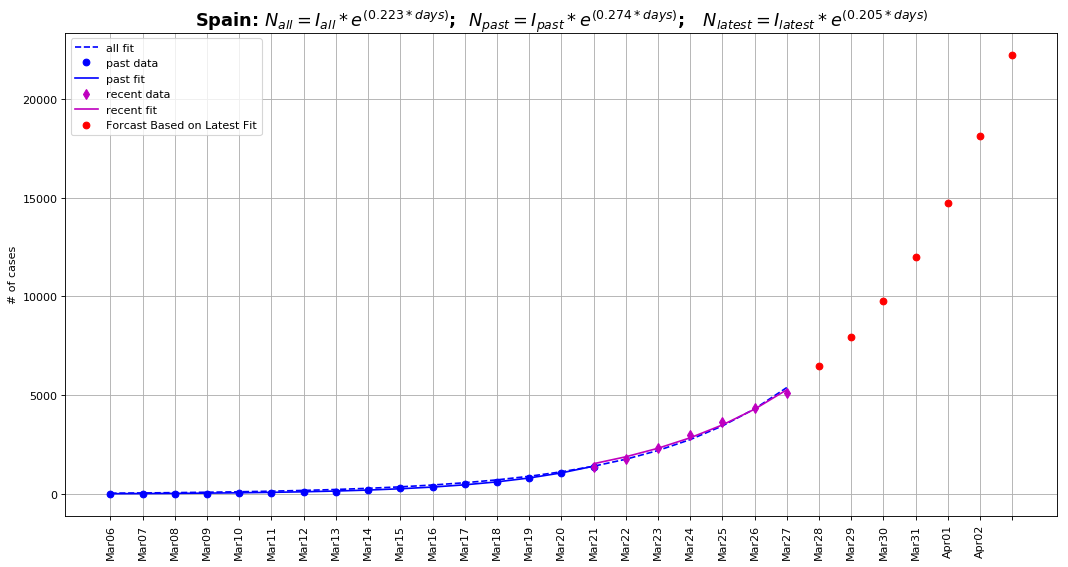

In [7]:
analyze_case("Spain")

Exponent Values:
  all data     = 0.239
  old data     = 0.316
  recent data  = 0.219
predicted cases at the end of next 7 days is [476856]


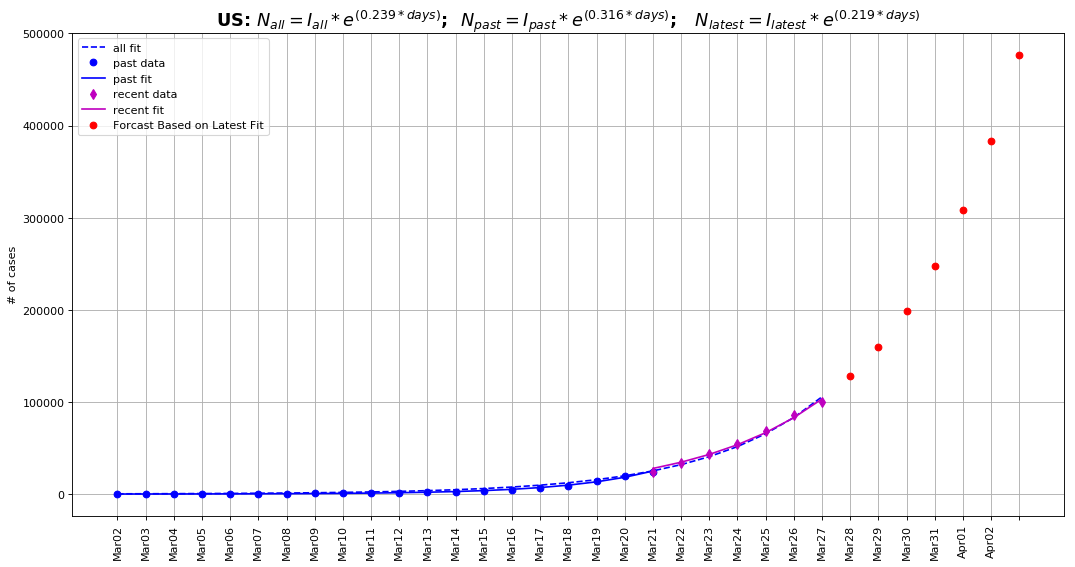

In [8]:
analyze_case("US")